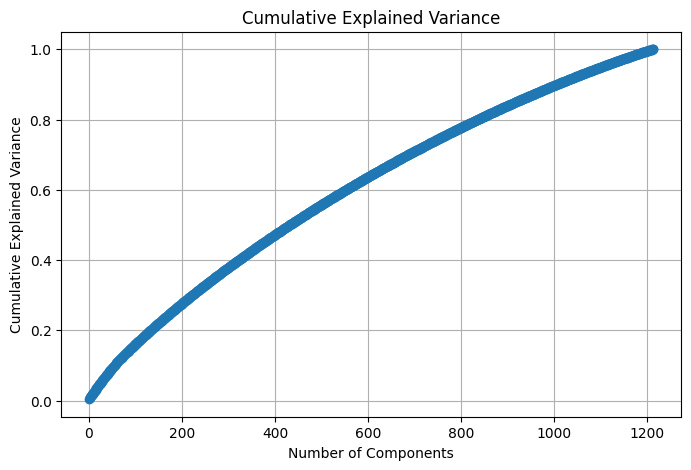

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# 🔹 Load fMRI Data
train_fmri_path = 'widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv' 
test_fmri_path = 'widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv'

train_fmri = pd.read_csv(train_fmri_path)
test_fmri = pd.read_csv(test_fmri_path)

# 🔹 Separate Participant ID (keep for reference)
train_ids = train_fmri[['participant_id']]
test_ids = test_fmri[['participant_id']]

# 🔹 Remove ID column for processing
train_features = train_fmri.drop(columns=['participant_id'])
test_features = test_fmri.drop(columns=['participant_id'])

# 🔹 Standardize the Data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)

# 🔹 Apply Truncated SVD on Train Set Only
n_components = min(train_scaled.shape)  # Limit by dataset shape
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(train_scaled)

# Calculate cumulative explained variance
explained_variance = np.cumsum(svd.explained_variance_ratio_)

# 🔹 Plot Explained Variance to Choose Components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# 🔹 Select optimal number of components (e.g., 95% explained variance)
optimal_n_components = np.argmax(explained_variance >= 0.90) + 1  # First index where variance ≥ 95%

# 🔹 Transform train & test using the SAME SVD model
svd_final = TruncatedSVD(n_components=optimal_n_components, random_state=42)
train_svd = svd_final.fit_transform(train_scaled)  # Fit on train
test_svd = svd_final.transform(test_scaled)  # Transform test with the same model

# 🔹 Convert back to DataFrame and restore Participant ID
train_svd_df = pd.DataFrame(train_svd, columns=[f"svd_{i+1}" for i in range(optimal_n_components)])
test_svd_df = pd.DataFrame(test_svd, columns=[f"svd_{i+1}" for i in range(optimal_n_components)])

# Convert to 1D array before inserting
train_svd_df.insert(0, "participant_id", train_ids.values.squeeze())  
test_svd_df.insert(0, "participant_id", test_ids.values.squeeze())

# ✅ Now train_svd_df and test_svd_df contain **participant_id** + **SVD features**



In [7]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


# --- Custom Dataset for Multi-Task Learning ---
class MultiTaskDataset(Dataset):
    def __init__(self, df, target_cols):
        self.y = df[target_cols].values.astype(np.float32)
        self.X = df.drop(columns=target_cols + ['participant_id']).values.astype(np.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  # y is a vector of targets

# --- Custom Weighted Loss Function ---
class WeightedBCELoss(nn.Module):
    def __init__(self):
        super(WeightedBCELoss, self).__init__()

    def forward(self, preds, target, sex, adhd):
        # Assign a weight of 2 for female ADHD cases (Sex_F=1, ADHD_Outcome=1)
        weights = torch.ones_like(target[:, 0])  # Default weight is 1, shape (batch_size,)
        weights[(sex == 1) & (adhd == 1)] = 2  # Apply weight of 2 for female ADHD cases
        
        # Compute the loss for each task
        loss_sex = nn.BCELoss(reduction='none')(preds[:, 0], target[:, 0])  # Loss for Sex_F
        loss_adhd = nn.BCELoss(reduction='none')(preds[:, 1], target[:, 1])  # Loss for ADHD_Outcome
        
        # Apply the weights to each task's loss
        weighted_loss_sex = loss_sex * weights  # Apply weight for Sex_F loss
        weighted_loss_adhd = loss_adhd * weights  # Apply weight for ADHD_Outcome loss

        return (weighted_loss_sex.mean() + weighted_loss_adhd.mean()) / 2

# --- Multi-Task Neural Network ---
class MultiTaskNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3):
        super(MultiTaskNN, self).__init__()
        # Shared layers with dropout
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),  # Dropout added here
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate)  # Dropout added here
        )
        # Separate heads for each task
        self.sex_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        self.adhd_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        shared_rep = self.shared(x)
        sex_pred = self.sex_head(shared_rep)
        adhd_pred = self.adhd_head(shared_rep)
        return torch.cat([sex_pred, adhd_pred], dim=1)  # output size [batch_size, 2]

# --- F1 Score Calculation with Weights ---
def weighted_f1_score(preds, target, sex, adhd):
    weights = np.ones_like(target[:, 0])  # Default weight is 1 for both tasks
    weights[(sex == 1) & (adhd == 1)] = 2  # Apply weight of 2 for female ADHD cases
    
    # Calculate F1 score for both tasks
    f1_sex = f1_score(target[:, 0], (preds[:, 0] > 0.5).astype(int), sample_weight=weights)
    f1_adhd = f1_score(target[:, 1], (preds[:, 1] > 0.5).astype(int), sample_weight=weights)
    
    return (f1_sex + f1_adhd) / 2

# --- Training Loop ---
def train_model(df, target_cols, num_epochs=100, batch_size=64, learning_rate=0.0001, weight_decay=0.01, dropout_rate=0.2):
    # Set device (this should be defined before using it)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Split the data into training and validation sets (80-20 split)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Create datasets and dataloaders
    train_dataset = MultiTaskDataset(train_df, target_cols)
    val_dataset = MultiTaskDataset(val_df, target_cols)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize the model
    input_dim = train_df.drop(columns=target_cols + ['participant_id']).shape[1]
    model = MultiTaskNN(input_dim, dropout_rate).to(device)
    
    # Initialize custom weighted loss
    criterion = WeightedBCELoss()

    # Define optimizer with weight decay (L2 regularization)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    best_val_f1 = 0  # For tracking best F1 score
    model_weights_per_epoch = []  # Store model weights at each epoch
    val_f1_scores = []  # Store F1 scores for validation

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            sex = y_batch[:, 0]  # Extract Sex_F values
            adhd = y_batch[:, 1]  # Extract ADHD_Outcome values
            
            optimizer.zero_grad()
            preds = model(X_batch)
            
            # Calculate weighted loss
            loss = criterion(preds, y_batch, sex, adhd)
            
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        avg_train_loss = np.mean(train_losses)
        
        # --- Validation ---
        model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(X_batch)
                all_preds.append(outputs.cpu().numpy())
                all_targets.append(y_batch.cpu().numpy())
        
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        
        # Calculate weighted F1 score for both tasks
        f1_score_avg = weighted_f1_score(all_preds, all_targets, all_targets[:, 0], all_targets[:, 1])
        
        print(f"Epoch {epoch+1}/{num_epochs} - Val Weighted F1 Score: {f1_score_avg:.4f}")
        
        # Store model weights and validation F1 score
        model_weights_per_epoch.append(model.state_dict())  # Save weights
        val_f1_scores.append(f1_score_avg)  # Save validation score

    # After training, find the epoch with the best validation F1 score
    best_epoch = np.argmax(val_f1_scores)  # Get the index of the best F1 score
    print(f"Best epoch: {best_epoch + 1} with F1 Score: {val_f1_scores[best_epoch]:.4f}")
    
    # Reload the best model weights
    model.load_state_dict(model_weights_per_epoch[best_epoch])  # Load best model weights
    return model




In [8]:
# Load target data (ensure correct file path)
target_file_path = 'widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx' 
target_data = pd.read_excel(target_file_path)

# Merge the target labels with the training data using `participant_id`
train_data_with_targets = pd.merge(train_svd_df, target_data, on='participant_id', how='inner')

# Define target columns for ADHD and Sex
target_cols = ['ADHD_Outcome', 'Sex_F']

# Train the model
trained_model = train_model(train_data_with_targets, target_cols, num_epochs=100, batch_size=32, learning_rate=0.0001, weight_decay=0.01, dropout_rate=0.2)

Epoch 1/100 - Val Weighted F1 Score: 0.4128
Epoch 2/100 - Val Weighted F1 Score: 0.4670
Epoch 3/100 - Val Weighted F1 Score: 0.5018
Epoch 4/100 - Val Weighted F1 Score: 0.5262
Epoch 5/100 - Val Weighted F1 Score: 0.5486
Epoch 6/100 - Val Weighted F1 Score: 0.5897
Epoch 7/100 - Val Weighted F1 Score: 0.5809
Epoch 8/100 - Val Weighted F1 Score: 0.6021
Epoch 9/100 - Val Weighted F1 Score: 0.6227
Epoch 10/100 - Val Weighted F1 Score: 0.6335
Epoch 11/100 - Val Weighted F1 Score: 0.6372
Epoch 12/100 - Val Weighted F1 Score: 0.6794
Epoch 13/100 - Val Weighted F1 Score: 0.6235
Epoch 14/100 - Val Weighted F1 Score: 0.6705
Epoch 15/100 - Val Weighted F1 Score: 0.6757
Epoch 16/100 - Val Weighted F1 Score: 0.6672
Epoch 17/100 - Val Weighted F1 Score: 0.6794
Epoch 18/100 - Val Weighted F1 Score: 0.6747
Epoch 19/100 - Val Weighted F1 Score: 0.6835
Epoch 20/100 - Val Weighted F1 Score: 0.6891
Epoch 21/100 - Val Weighted F1 Score: 0.6866
Epoch 22/100 - Val Weighted F1 Score: 0.6872
Epoch 23/100 - Val 

In [9]:
import pandas as pd
import torch

def predict_and_save_csv(trained_model, test_df, device, output_path='test_predictions.csv'):
    # Ensure `test_df` does not contain `participant_id` in the model input
    test_ids = test_df[['participant_id']]  # Keep IDs for reference
    X_test = test_df.drop(columns=['participant_id'])  # Remove ID for model input

    # Ensure all data is numeric
    X_test = X_test.apply(pd.to_numeric, errors='coerce')

    # Handle missing values by filling with the **same strategy** used in training
    X_test.fillna(X_test.mean(), inplace=True)

    # Convert to torch tensor and move to the appropriate device
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    
    # Set model to evaluation mode and make predictions
    trained_model.eval()
    with torch.no_grad():
        outputs = trained_model(X_test_tensor)
        
        # Convert probabilities to binary classification (0 or 1)
        predictions = (outputs.cpu().numpy() > 0.5).astype(int)
    
    # Prepare DataFrame with predictions
    results = pd.DataFrame(predictions, columns=['Sex_F', 'ADHD_Outcome'])
    
    # Restore `participant_id` (ensuring it's correctly formatted)
    results.insert(0, 'participant_id', test_ids.values.squeeze())

    # Save predictions to CSV
    results.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")


# 🔹 Usage: Ensure test data is correctly preprocessed before calling function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predict_and_save_csv(trained_model, test_svd_df, device, output_path='fmri_predictions.csv')

Predictions saved to fmri_predictions.csv
